## Bonus

In [1]:
### Common imports
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import math
### Custom functions
from src.rbm import RBM
from src.dbn import DBN
from src.dnn import DNN
from src.data import get_mnist, get_binaryalphadigts
from src.utils import KL

##VAE
import torch
from torch import nn
from torch.optim import Adam

### MNIST

In [2]:
X_train, X_test, y_train, y_test = get_mnist()

cfg_train = {
    "n_epoches":100,
    "lr":0.1,
    "batch_size":64,
    "shuffle":True
}

cfg_gibbs = {
    "n_images":9,
    "n_iters":1000,
}

cfg_rbm = {
    "in_channels":784, 
    "out_channels":64,
}

In [3]:
raw_shape = (28, 28)
rbm = RBM(**cfg_rbm)
losses_rbm = rbm.train_RBM(X_train, **cfg_train)

  0%|          | 0/100 [00:00<?, ?it/s]

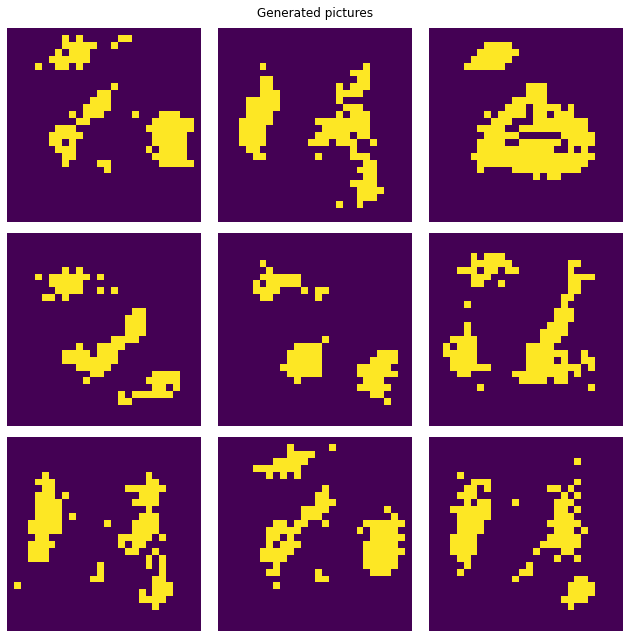

In [4]:
output = rbm.sample_Gibbs(**cfg_gibbs).reshape(-1, *raw_shape)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9, 9))
plt.suptitle("Generated pictures")
for i in range(3):
    axs[i, 0].imshow(output[i*3+0])
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(output[i*3+1])
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(output[i*3+2])
    axs[i, 2].axis("off")
    
plt.tight_layout()
plt.show()

#### VAE

In [5]:
cfg_train = {
    "n_epoches":100,
    "lr":0.001,
    "batch_size":64,
    "shuffle":True,
    "kl_sigma":1,
}

In [6]:
enc = nn.Sequential(
    nn.Linear(784, 64)
)

std_layer = nn.Sequential(
    nn.Linear(64, 64)
)

mean_layer = nn.Sequential(
    nn.Linear(64, 64)
)

dec = nn.Sequential(
    nn.Linear(64, 784),
    nn.Sigmoid()
)

model_all = nn.ModuleList([
    enc,
    std_layer,
    mean_layer,
    dec
])

opt = Adam(model_all.parameters(), lr=cfg_train["lr"])
mse = nn.MSELoss(reduction="mean")

In [7]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

dataloader_train = DataLoader(X_train_tensor, batch_size=cfg_train["batch_size"], shuffle=cfg_train["shuffle"])
dataloader_test = DataLoader(X_test_tensor, batch_size=cfg_train["batch_size"], shuffle=cfg_train["shuffle"])

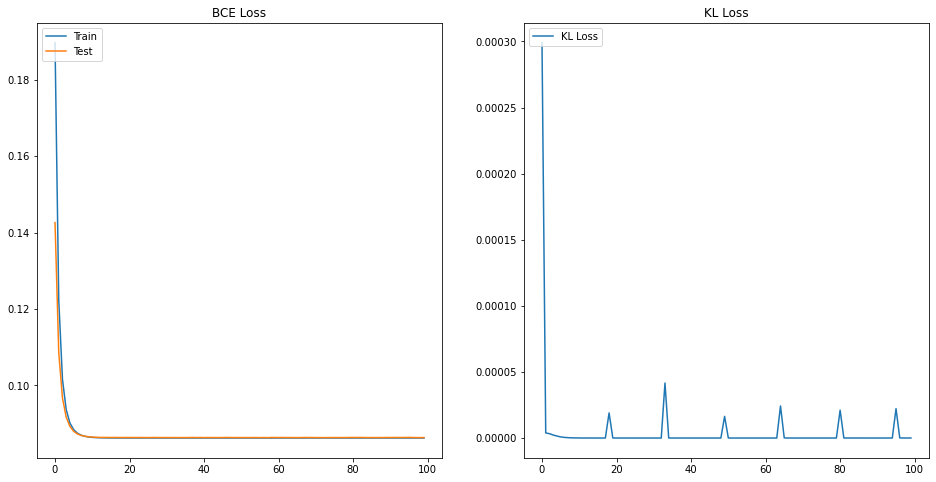

In [8]:
losses_vae_train = []
losses_KL_train = []
losses_vae_test = []

for n in range(cfg_train["n_epoches"]):
    n_elem = 0
    err_train = 0
    kl_train = 0
    
    err_test = 0
    
    for X_batch in dataloader_train:
        size_batch = X_batch.shape[0]
        n_elem += size_batch
        opt.zero_grad()
        encoding = enc(X_batch)
        mu = mean_layer(encoding)
        log_var = std_layer(encoding)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + std*eps
        
        bce_loss = mse(dec(z), X_batch)
        err_train += bce_loss.item()*size_batch
        
        kl_loss = KL(log_var, mu)
        kl_train += kl_loss.item()
        
        loss = bce_loss + cfg_train["kl_sigma"]*kl_loss
        loss.backward()
        opt.step()
    
    losses_vae_train.append(err_train/n_elem)
    losses_KL_train.append(kl_train/n_elem)
    n_elem = 0
    
    with torch.no_grad():
        for X_batch in dataloader_test:
            size_batch = X_batch.shape[0]
            n_elem += size_batch
            encoding = enc(X_batch)
            mu = mean_layer(encoding)
            log_var = std_layer(encoding)
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            z = mu + std*eps
            
            err_test += mse(dec(z), X_batch).item()*size_batch
        
    losses_vae_test.append(err_test/n_elem)

    clear_output(wait=True)
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
    ax1 = axs[0]

    ax1.plot(losses_vae_train, label="Train")
    ax1.plot(losses_vae_test, label="Test")
    ax1.legend(loc='upper left')
    ax1.set_title("BCE Loss")

    ax2 = axs[1]
    ax2.plot(losses_KL_train, label="KL Loss")
    ax2.legend(loc='upper left')
    ax2.set_title("KL Loss")

    plt.show()

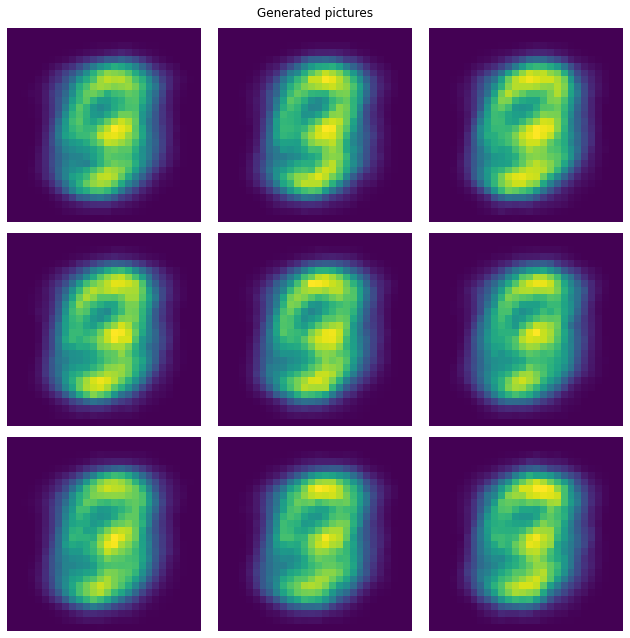

In [9]:
with torch.no_grad():
    sample = torch.empty((cfg_gibbs["n_images"], 64)).normal_(mean=0,std=1)
    output = (dec(sample)).numpy().reshape(-1, *raw_shape)

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9, 9))
plt.suptitle("Generated pictures")
for i in range(3):
    axs[i, 0].imshow(output[i*3+0])
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(output[i*3+1])
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(output[i*3+2])
    axs[i, 2].axis("off")
    
plt.tight_layout()
plt.show()

### AlphaDigits

In [10]:
keys_to_idx, idx_to_keys, key_to_set = get_binaryalphadigts()
X_ordered = np.concatenate(list(key_to_set.values()))
labels = [np.ones(key_to_set[keys_to_idx[key]].shape[0], dtype=int)*key for key in range(36)]
y_ordered = np.concatenate(labels)
y_one_hot = np.zeros((y_ordered.size, y_ordered.max()+1))
y_one_hot[np.arange(y_ordered.size), y_ordered] = 1
X_train, X_test, y_train, y_test = train_test_split(
                                        X_ordered,
                                        y_one_hot,
                                        test_size=0.25,
                                        shuffle=True)

cfg_train = {
    "n_epoches":100,
    "lr":0.1,
    "batch_size":64,
    "shuffle":True
}

cfg_gibbs = {
    "n_images":9,
    "n_iters":1000,
}

cfg_rbm = {
    "in_channels":20*16, 
    "out_channels":64,
}

In [11]:
raw_shape = (20, 16)
rbm = RBM(**cfg_rbm)
losses_rbm = rbm.train_RBM(X_train, **cfg_train)

  0%|          | 0/100 [00:00<?, ?it/s]

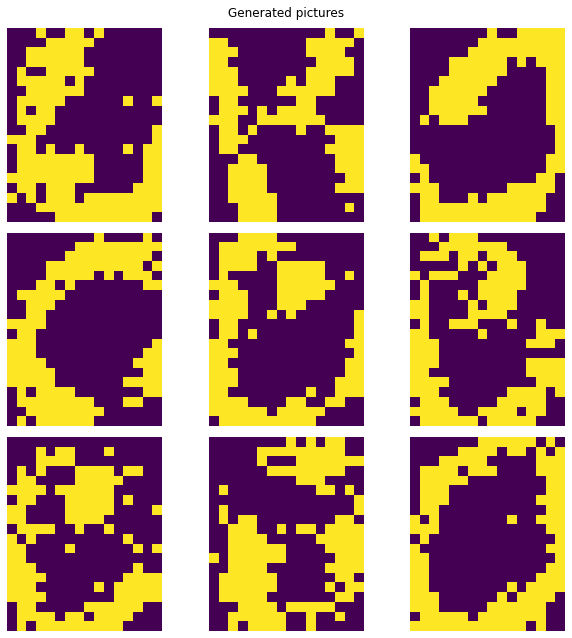

In [12]:
output = rbm.sample_Gibbs(**cfg_gibbs).reshape(-1, *raw_shape)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9, 9))
plt.suptitle("Generated pictures")
for i in range(3):
    axs[i, 0].imshow(output[i*3+0])
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(output[i*3+1])
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(output[i*3+2])
    axs[i, 2].axis("off")
    
plt.tight_layout()
plt.show()

#### VAE

In [13]:
cfg_train = {
    "n_epoches":500,
    "lr":0.001,
    "batch_size":32,
    "shuffle":True,
    "kl_sigma":1,
}

In [14]:
enc = nn.Sequential(
    nn.Linear(20*16, 64)
)

std_layer = nn.Sequential(
    nn.Linear(64, 64)
)

mean_layer = nn.Sequential(
    nn.Linear(64, 64)
)

dec = nn.Sequential(
    nn.Linear(64, 20*16),
    nn.Sigmoid()
)

model_all = nn.ModuleList([
    enc,
    std_layer,
    mean_layer,
    dec
])

opt = Adam(model_all.parameters(), lr=cfg_train["lr"])
mse = nn.MSELoss(reduction="mean")

In [15]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

dataloader_train = DataLoader(X_train_tensor, batch_size=cfg_train["batch_size"], shuffle=cfg_train["shuffle"])
dataloader_test = DataLoader(X_test_tensor, batch_size=cfg_train["batch_size"], shuffle=cfg_train["shuffle"])

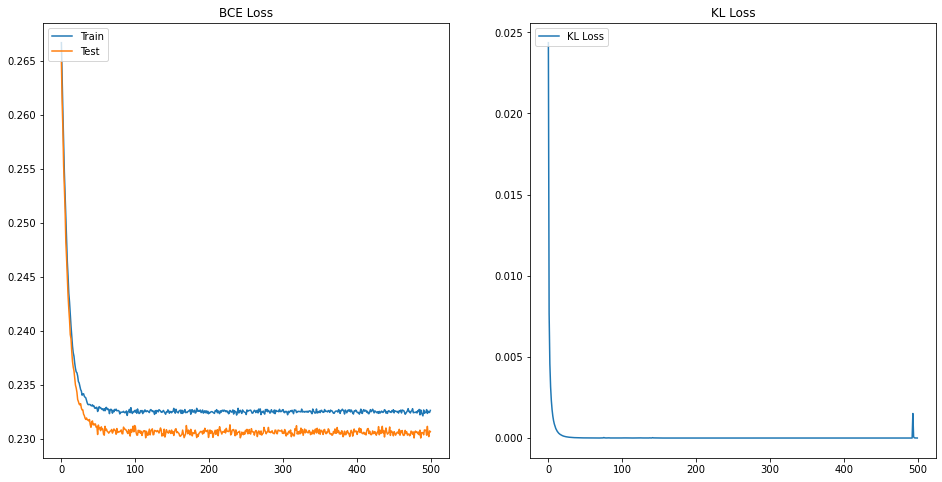

In [16]:
losses_vae_train = []
losses_KL_train = []
losses_vae_test = []

for n in range(cfg_train["n_epoches"]):
    n_elem = 0
    err_train = 0
    kl_train = 0
    
    err_test = 0
    
    for X_batch in dataloader_train:
        size_batch = X_batch.shape[0]
        n_elem += size_batch
        opt.zero_grad()
        encoding = enc(X_batch)
        mu = mean_layer(encoding)
        log_var = std_layer(encoding)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + std*eps
        
        bce_loss = mse(dec(z), X_batch)
        err_train += bce_loss.item()*size_batch
        
        kl_loss = KL(log_var, mu)
        kl_train += kl_loss.item()
        
        loss = bce_loss + cfg_train["kl_sigma"]*kl_loss
        loss.backward()
        opt.step()
    
    losses_vae_train.append(err_train/n_elem)
    losses_KL_train.append(kl_train/n_elem)
    n_elem = 0
    
    with torch.no_grad():
        for X_batch in dataloader_test:
            size_batch = X_batch.shape[0]
            n_elem += size_batch
            encoding = enc(X_batch)
            mu = mean_layer(encoding)
            log_var = std_layer(encoding)
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            z = mu + std*eps
            
            err_test += mse(dec(z), X_batch).item()*size_batch
        
    losses_vae_test.append(err_test/n_elem)

    clear_output(wait=True)
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
    ax1 = axs[0]

    ax1.plot(losses_vae_train, label="Train")
    ax1.plot(losses_vae_test, label="Test")
    ax1.legend(loc='upper left')
    ax1.set_title("BCE Loss")

    ax2 = axs[1]
    ax2.plot(losses_KL_train, label="KL Loss")
    ax2.legend(loc='upper left')
    ax2.set_title("KL Loss")

    plt.show()

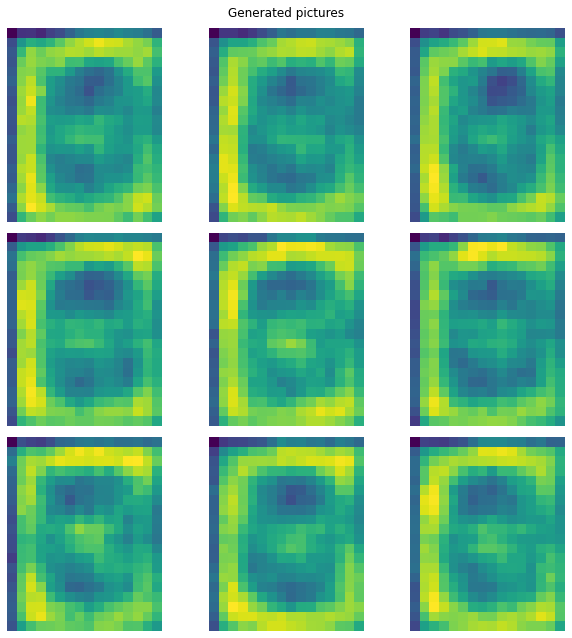

In [17]:
with torch.no_grad():
    sample = torch.empty((cfg_gibbs["n_images"], 64)).normal_(mean=0,std=1)
    output = (dec(sample)).numpy().reshape(-1, *raw_shape)

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9, 9))
plt.suptitle("Generated pictures")
for i in range(3):
    axs[i, 0].imshow(output[i*3+0])
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(output[i*3+1])
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(output[i*3+2])
    axs[i, 2].axis("off")
    
plt.tight_layout()
plt.show()